# TSP Environment

We follow [this guide](https://pytorch.org/rl/tutorials/pendulum.html) for implementing the environment in TorchRL and the following implementations:
- https://github.com/wouterkool/attention-learn-to-route/tree/master/problems/tsp
- https://github.com/yd-kwon/POMO/blob/master/NEW_py_ver/TSP/POMO/TSPEnv.py

Our scope is to integrate everything with the PyTorch Lightning framework: you may have a look this [notebook](https://github.com/fedebotu/lightning-torchrl/blob/main/1.pendulum-lightning-torchrl.ipynb) to get a rough idea ^^

We will try to make the environment `stateteless`, i.e. the environment will not store the state (we just pass everything in TensorDicts). This is supposed to have better properties than _stateful_ implementations, like the ones above.

In [1]:
%matplotlib inline

# Rich Traceback is a library that makes tracebacks more readable
# from rich.traceback import install
# install(show_locals=True)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(2*"../")

from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, UnboundedDiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp


from ncobench.envs.utils import make_composite_from_td, batch_to_scalar, _set_seed

### Making the custom environment

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (`td` in the code) of the current state and the action to take:

In [3]:
def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]
    first_node = current_node if batch_to_scalar(td["i"]) == 0 else td["first_node"]

    # Set visited to 1
    visited = td["visited"].scatter(
        -1, current_node[..., None].expand_as(td["visited"]), 1
    )

    # We are done if all the locations have been visited
    done = (
        torch.count_nonzero(visited.squeeze(), dim=-1) >= self.num_loc
    )  # td["params"]["num_loc"]

    # Calculate reward (minus length of path, since we want to maximize the reward -> minimize the path length)
    # NOTE: reward is calculated outside for now via the get_reward function
    # to calculate here need to pass action sequence or save it as state
    reward = torch.ones_like(done) * float("-inf")

    # The output must be written in a ``"next"`` entry
    return TensorDict(
        {
            "next": {
                "observation": td["observation"],
                "first_node": first_node,
                "current_node": current_node,
                "visited": visited,
                "i": td["i"] + 1,
                "action_mask": visited == 0,
                "reward": reward,
                "done": done,
            }
        },
        td.shape,
    )


### Environment Reset
This defines the `_reset` of the TSP. It returns a TensorDict of the initial state:

In [4]:
def _reset(
    self, td: Optional[TensorDict] = None, init_observation=None, batch_size=None
) -> TensorDict:
    # If no tensordict is passed, we generate a single set of hyperparameters
    # Otherwise, we assume that the input tensordict contains all the relevant parameters to get started.
    if batch_size is None:
        batch_size = (
            self.batch_size
            if init_observation is None
            else init_observation.shape[:-2]
        )
    device = (
        init_observation.device if init_observation is not None else self.device
    )
    self.device = device

    min_loc = self.min_loc
    max_loc = self.max_loc
    num_loc = self.num_loc

    # We allow loading the initial observation from a dataset for faster loading
    if init_observation is None:
        loc = (
            torch.rand((*batch_size, num_loc, 2), generator=self.rng)
            * (max_loc - min_loc)
            + min_loc
        ).to(
            device
        )  # number generator is on CPU by default, set device after
    else:
        loc = init_observation

    # Other variables
    current_node = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)
    visited = torch.zeros(
        (*batch_size, 1, num_loc), dtype=torch.bool, device=device
    )
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "observation": loc,
            "first_node": current_node,
            "current_node": current_node,
            "visited": visited,
            "i": i,
            "action_mask": visited == 0,
        },
        batch_size=batch_size,
    )

### Environment metadata 

This defines the input and output domains of the environment - similar to Gym's `spaces`:

In [5]:
def _make_spec(self):
    """Make the observation and action specs from the parameters"""
    # params = td_params["params"]
    # num_loc = params["num_loc"]  # TSP size
    num_loc = self.num_loc
    self.observation_spec = CompositeSpec(
        observation=BoundedTensorSpec(
            # minimum=params["min_loc"],
            # maximum=params["max_loc"],
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(num_loc, 2),
            dtype=torch.float32,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        visited=UnboundedDiscreteTensorSpec(
            shape=(1, num_loc),
            dtype=torch.bool,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(1, num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))

## Reward function

Sometimes, we want to make it simpler to get the reward outside. Normally, each step should give a reward; but in our case, reward is $-\infty$ unless finished The reason is that normally, we would have to collect all the previous locations and actions _inside_ the environment. But since the model already does that at the end, we can simply call the `get_reward` function to get the reward more efficiently.


In [6]:
def get_reward(loc, actions) -> TensorDict:
    assert (
        torch.arange(actions.size(1), out=actions.data.new())
        .view(1, -1)
        .expand_as(actions)
        == actions.data.sort(1)[0]
    ).all(), "Invalid tour"

    # Gather locations in order of tour
    locs = loc.gather(1, actions.unsqueeze(-1).expand_as(loc))

    # Return the length of the path (L2-norm of difference from each next location from its previous and of last from first)
    locs_next = torch.roll(locs, 1, dims=1)
    return -((locs_next - locs).norm(p=2, dim=2).sum(1))

### Environment creation

Here we use `EnvBase` to create the environment similarly to gym:

In [7]:
class TSPEnv(EnvBase):
    batch_locked = False
    name = "tsp"

    def __init__(
        self,
        num_loc: int = 10,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        seed: int = None,
        device: str = "cpu",
    ):
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc

        super().__init__(device=device, batch_size=[])
        # self._make_spec(td_params)
        self._make_spec()
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    # gen_params = gen_params # we don't use it for this case. See notebook 0
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = _step
    _set_seed = _set_seed

    # Get reward
    get_reward = staticmethod(get_reward)

### Testing the environment

In [8]:
env = TSPEnv(num_loc=5)
check_env_specs(env)

check_env_specs succeeded!


In [9]:
td = env.reset()
for i in range(3):
    td.set("action", torch.tensor([i]))
    print(td['action'])
    td = env.step(td)['next']
    print("visited2", td['visited'])
    td.set("action", torch.tensor([i]))
    td = env.step(td)['next']

tensor([0])
visited2 tensor([[ True, False, False, False, False]])
tensor([1])
visited2 tensor([[ True,  True, False, False, False]])
tensor([2])
visited2 tensor([[ True,  True,  True, False, False]])


### Plotting

In [10]:
# Reset seed : check_env_specs(env) sets the seed to 0 for testing 
seed = torch.empty((), dtype=torch.int64).random_().item()
env.set_seed(seed)

275112776

In [13]:
rollout

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        action_mask: Tensor(shape=torch.Size([512, 5, 1, 5]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                action_mask: Tensor(shape=torch.Size([512, 5, 1, 5]), device=cpu, dtype=torch.bool, is_shared=False),
                current_node: Tensor(shape=torch.Size([512, 5, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                done: Tensor(shape=torch.Size([512, 5, 1]), device

In [11]:
# Make a rollout
rollout = env.rollout(
    20,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(batch_size=[512]),
    break_when_any_done=True
)

# Get the last rollout
rollout_ = rollout['next']
rollout_finished = rollout_[(rollout_['done'] == 1).squeeze()]

# Get the reward afterwards
observations = rollout['observation'][(rollout_['done'] == 1).squeeze()]
actions = rollout['action'][(rollout_['done'][:, -1] == 1).squeeze()].squeeze()
rewards = env.get_reward(observations, actions)
rollout_finished['reward'][:, -1] = rewards

In [41]:
import matplotlib.pyplot as plt


def render_tsp(td):
    td = td.detach().cpu()
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]

    key = 'observation' if 'observation' in td.keys() else 'loc'

    # Get the coordinates of the visited nodes for the first batch element
    visited_coords = td[key][td['visited'][0, 0] == 1][0]

    # Create a plot of the nodes
    fig, ax = plt.subplots()
    ax.scatter(td[key][:, 0], td[key][:, 1], color='blue')

    # Plot the visited nodes
    ax.scatter(visited_coords[:, 0], visited_coords[:, 1], color='red')

    # Add arrows between visited nodes as a quiver plot
    x = visited_coords[:, 0]
    y = visited_coords[:, 1]
    dx = np.diff(x)
    dy = np.diff(y)

    # Colors via a colormap
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(vmin=0, vmax=len(x))
    colors = cmap(norm(range(len(x))))

    ax.quiver(x[:-1], y[:-1], dx, dy, scale_units='xy', angles='xy', scale=1, color=colors)

    # Add final arrow from last node to first node
    ax.quiver(x[-1], y[-1], x[0]-x[-1], y[0]-y[-1], scale_units='xy', angles='xy', scale=1, color="red", linestyle="dashed")

    # Plot numbers inside circles next to visited nodes
    for i, coord in enumerate(visited_coords):
        ax.add_artist(plt.Circle(coord, radius=0.02, color=colors[i]))
        ax.annotate(str(i+1), xy=coord, fontsize=10, color='white',
                    va="center", ha="center")

    # Set plot title and axis labels
    ax.set_title('TSP Solution\nTotal length: {:.2f}'.format(-td['reward'][0]))
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    ax.set_aspect('equal')

    plt.show()

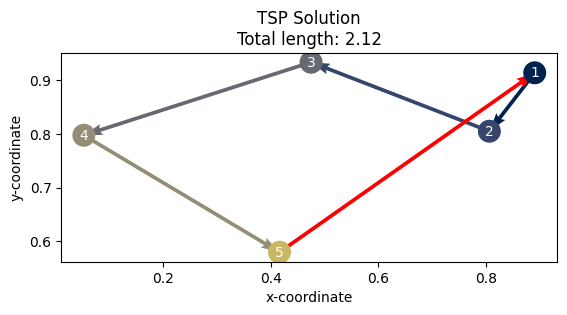

In [42]:
render_tsp(rollout_finished)